In [68]:
import pickle
import random
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
% config InlineBackend . figure_format = 'svg'

In [3]:
def loadfile(path):
    with open(path,'rb') as picklefile:
        file = pickle.load(picklefile, encoding='latin1')
    return file

In [6]:
q1_newman_w = loadfile('./data/2016_q1_newman-weights_kcore.pickle')
q2_newman_w = loadfile('./data/2016_q2_newman-weights_kcore.pickle')
q1_cci = loadfile('./data/2016_q1_cci-weights_kcore.pickle')

In [7]:
nm_cn = loadfile('./data/newman_cn_kcore.pickle')
nm_aa = loadfile('./data/newman_adam_kcore.pickle')
nm_jc = loadfile('./data/newman_jaccard_kcore.pickle')
nm_pa = loadfile('./data/newman_pa_kcore.pickle')
cci_cn = loadfile('./data/CII_cn.pickle')
cci_aa = loadfile('./data/CII_adam.pickle')
cci_jc = loadfile('./data/CII_jaccard.pickle')
cci_pa = loadfile('./data/CII_pa.pickle')

In [8]:
nm_katz = loadfile('./data/newman_katz_weighted_0_00005.pickle')
unweighted_katz = loadfile('./data/newman_katz_unweighted_0_00005.pickle')
cci_katz = loadfile('./data/cci_katz_weighted_0_00005.pickle')

## Construct dataframe for supervised learning

In [10]:
# Get new core edges
nce = list(set(nm_pa.keys()).difference(q1_newman_w.keys()))

In [11]:
def combine_scores(edges, score_list):
    scores = np.zeros((len(edges), len(score_list)))
    for i in range(len(edges)):
        for j in range(len(score_list)):
            scores[i][j] = score_list[j][edges[i]]
    return scores

In [12]:
X = combine_scores(nce, [nm_cn, nm_aa, nm_jc, nm_pa, cci_cn, cci_aa, cci_jc, cci_pa, nm_katz, unweighted_katz, cci_katz])
y = [a in q2_newman_w.keys() for a in nce]

## Combine with user behavior and demographic features

In [28]:
user_details = loadfile('./data/user_details.pickle')
nm_community = loadfile('./data/author_clusters_2016_q1_k25core_newman.pickle')
cii_community = loadfile('./data/author_clusters_2016_q1_k25core_cii.pickle')

In [18]:
user_details.shape

(3053, 7)

In [19]:
user_country = user_details.country_code.to_dict()
user_created = user_details.months_since_1970.to_dict()
user_commit = user_details.commit_times.to_dict()

In [30]:
def get_user_details(edges, detail_list):
    details = np.zeros((len(edges), len(detail_list)))
    #print (f'{len(edges)/1000}k node pairs to process')
    for i in range(len(edges)):
        #if not i%10000:
        #    print (f'Processing {i/1000}k th node pair')
        uid = edges[i][0]
        vid = edges[i][1]
        details[i][0] = int(detail_list[0][uid] == detail_list[0][vid])
        details[i][1] = abs(detail_list[1][uid] - detail_list[1][vid])
        details[i][2] = min(detail_list[2][uid], detail_list[2][vid]) == 0
        details[i][3] = int(detail_list[3][uid]==detail_list[3][vid])
        details[i][4] = int(detail_list[4][uid]==detail_list[4][vid])
    return details

In [31]:
details = get_user_details(nce, [user_country, user_created, user_commit, nm_community, cii_community])
X_new = np.concatenate((X, details), axis=1)

## Build a baseline model with logistic regression

In [47]:
# Divide data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=1234, stratify=y)
# Downsample the training set
rus = RandomUnderSampler()
X_under, y_under = rus.fit_sample(X_train, y_train)
ssX = StandardScaler()
X_scaled = ssX.fit_transform(X_under)

In [48]:
models = [
          ('logistic', LogisticRegression),
          ('tree', DecisionTreeClassifier),
          ('forest', RandomForestClassifier),
          ('xgboost', XGBClassifier)
         ]

param_choices = [    
    {
        'C': np.logspace(-3, 6, 12),
        'penalty': ['l1', 'l2']
    },
    {
        'max_depth': [1,2,3,4,5],
        'min_samples_leaf': [1,3,5]
    },
    {
        'criterion':['gini','entropy'],
        'n_estimators': [40,50,60],
        'min_samples_leaf':[1,3],
        'min_samples_split':[2,5]
    },
    {
        'max_depth': [3,4,5],
        'n_estimators': [1, 50, 100,200],
        'objective':['binary:logistic']
    }
]

grids = {}
for model_info, params in zip(models, param_choices):
    name, model = model_info
    grid = GridSearchCV(model(), params, scoring='accuracy', cv=5, n_jobs=-1)
    grid.fit(X_scaled, y_under)
    s = "{}: best score: {}".format(name, grid.best_score_)
    print(s)
    grids[name] = grid

logistic: best score: 0.8732256355932203
tree: best score: 0.8991525423728813
forest: best score: 0.9291313559322034


/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py

/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/songlin/anaconda2/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/label.py

xgboost: best score: 0.9129502118644067


In [51]:
X_test_scaled = ssX.transform(X_train)

In [50]:
y_test_pred = [x[1] for x in grids['tree'].predict_proba(X_test_scaled)]

### Check training accuracy with the same method with similarity score

In [52]:
def check_prediction_accuracy(pred_prob, y):
    n = sum(y)
    sorted_index = [a for a,b in sorted(enumerate(pred_prob), key=lambda x:x[1], reverse=True)][:n]
    true_index = [a for a,b in enumerate(y) if b == 1]
    matches = set(sorted_index).intersection(true_index)
    return len(matches)/n

In [53]:
X_test_scaled = ssX.transform(X_train)
y_test_pred = [x[1] for x in grids['tree'].predict_proba(X_test_scaled)]
for model in grids.keys():
    X_train_scaled = ssX.transform(X_train)
    y_train_pred = [x[1] for x in grids[model].predict_proba(X_train_scaled)]
    print (f'Model {model} has an accuracy of {check_prediction_accuracy(y_train_pred, y_train)}')

Model logistic has an accuracy of 0.18585805084745763
Model tree has an accuracy of 0.1733050847457627
Model forest has an accuracy of 0.34835805084745763
Model xgboost has an accuracy of 0.23935381355932203


## Apply the best model on test data

In [54]:
X_test_scaled = ssX.transform(X_test)
y_test_pred = [x[1] for x in grids['forest'].predict_proba(X_test_scaled)]

In [55]:
check_prediction_accuracy(y_test_pred, y_test)

0.23692992213570635

## Check Feature Importance

In [63]:
def plot_importance(model, df, title, columns=None):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:]
    plt.figure()
    plt.axvline(x=1/df.shape[1], color='#1DB954')
    plt.title(title, fontsize=25)
    plt.barh(range(10), importances[indices], color='#FF5A60', align='center', )
    if (columns == None):
        plt.yticks(range(10), df.columns[indices])
    else:
        plt.yticks(range(10), columns)
    plt.xlabel('Relative Importance', fontsize=15)
    return plt

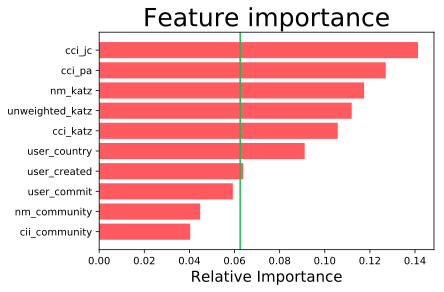

In [64]:
columns_name = (['nm_cn', 'nm_aa', 'nm_jc', 'nm_pa', 
                 'cci_cn', 'cci_aa', 'cci_jc', 'cci_pa', 
                 'nm_katz', 'unweighted_katz', 'cci_katz',
                 'user_country', 'user_created', 'user_commit', 
                 'nm_community', 'cii_community'])[::-1]
title = 'Feature importance'
plot_importance(grids['forest'].best_estimator_, X_scaled, title, columns=columns_name);

In [65]:
X_scaled.shape

(37760, 16)

## Learning Curve

In [66]:
# Check if more data would help

def drawLearningCurve(model, X, y, ylim_lower = -100, ylim_higher = 100, save=False):
    best_clas_fit = model.fit(X, y)
    train_sizes, train_scores, test_scores = learning_curve(best_clas_fit, X, y, cv=5)
    ave_train_scores = train_scores.mean(axis=1)
    ave_test_scores = test_scores.mean(axis=1)

    learn_df  = pd.DataFrame({
        'train_size': train_sizes,
        'train_score': ave_train_scores,
        'test_score': ave_test_scores
    })

    plot_lm_0 = plt.figure(1)
    plot_lm_0.set_figheight(6)
    plot_lm_0.set_figwidth(12)
    plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
    plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
    plt.legend(loc='lower right', fontsize=20)
    plt.xlabel('Training sizes', fontsize=20)
    plt.ylabel('Score', fontsize=20)
    plt.title('Learning Curve', fontsize=26)
    plt.ylim(ylim_lower,ylim_higher)
    if (save):
        plt.save('./data/img/learning_curve.png')

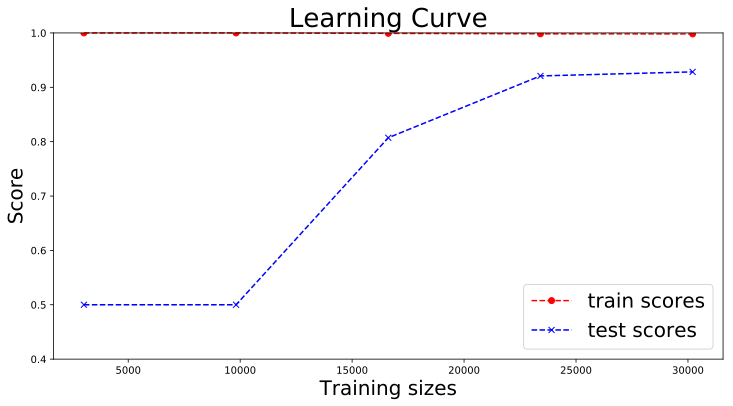

In [71]:
drawLearningCurve(grids['forest'].best_estimator_, X_scaled, y_under.ravel(), 0.4, 1)